In [1]:
from netCDF4 import Dataset

import numpy as np
import warnings
import glob, os
import cv2
os.chdir("PROJETS5")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from math import *

#Geodesic distance in km
def dist_geo(long1, lat1, long2, lat2):
    try:
        value= sin(lat1*2*pi/360)*sin(lat2*2*pi/360) + cos(lat1*2*pi/360)*cos(lat2*2*pi/360)\
                    *cos((long2 - long1)*2*pi/360)
        return acos(min(1,value))*6378
    except ValueError:
        print(long1, lat1, long2, lat2,sin(lat1*2*pi/360)*sin(lat2*2*pi/360) + cos(lat1*2*pi/360)*cos(lat2*2*pi/360)\
                    *cos((long2 - long1)*2*pi/360))

#Geodesic distance for vectors
vdist_geo = np.vectorize(dist_geo, excluded=['long1', 'lat1'])

#Returns the distances and indices of k-nearest neighbors from the point (long,lat)
def get_knearest(long, lat, points, indices, k):
    distances = vdist_geo(long, lat, points[:,0], points[:,1])
    s_distances, s_neigh = (np.array(t) for t in zip(*sorted(zip(distances, indices))))
    return s_distances[:k], s_neigh[:k]

#Compute alpha weight from i-th point in distances
def alpha(distances, i, coeff):
    return exp(-distances[i]/coeff)/sum(np.exp(-np.array(distances)/coeff))

#Compute alphas weights for all points in distances
def valpha(distances, coeff):
    l = len(distances)
    alphas = np.zeros((l,))
    for i in range(l):
        alphas[i] = alpha(distances, i, coeff)
    return alphas

def non_nan_hist(values, non_nan_indexes, bins):
    hist, b = np.histogram(values[non_nan_indexes], bins)
    hist = hist.ravel().astype('float32')
    return hist, b

In [3]:
st = "NATL12_*_nobs014*.nc"
n_iter = 0 #Number of time iterations 
for file in glob.glob(st):
    n_iter+= 1
print(n_iter)

30


In [4]:
warnings.filterwarnings('ignore')
st = "NATL12_*_nobs014*.nc"

n_iter = 0 #Number of time iterations 
for file in glob.glob(st):
    n_iter+= 1
    
doubt_coeff = 10 #coefficient which represents the doubt we have in the observed value. Used in the computation of the used_means
#which are a mixture of fixed class means and instant class means
#Fixed class means
gaus_means = np.array([7.70938140771444, 18.5364702094555, 15.4116575244064, 4.702268415742165])
gaus_vars = np.array([0.164338465357345, 1.27622462394194, 2.02625911575517, 0.232444749797503])
colors = ['g','r','y','b'] #Colors used to display classes

all_basic_temp = np.zeros((n_iter,127,254))
all_fixed_temp = np.zeros((n_iter,127,254))
all_adapt_temp = np.zeros((n_iter,127,254))
all_true_temp = np.zeros((n_iter,127,254))

ite = 0
for file in glob.glob(st):
    if ite%10 == 0:
        print('itération {}'.format(ite+1))
    dataset = Dataset(file)
    long = np.array(dataset['lon']) #Whole data longitudes
    lat = np.array(dataset['lat']) #Whole data latitudes
    lab = np.array(dataset['labels']) #Whole data classes
    lab = np.reshape(lab, (127,254))
    posteriors = dataset['posteriors'] #Whole data posteriors
    posteriors = np.reshape(posteriors,(4,127,254))
    obs_lon = dataset['obs_lon'] #Observations longtitudes
    obs_lat = dataset['obs_lat'] #Observations latitudes
    n_obs = len(obs_lon)
    obs_ilon = np.array(dataset['obs_ilon']).astype(int)-1 #Observations indices in "long"
    obs_ilat = np.array(dataset['obs_ilat']).astype(int)-1 #Observations indices in "lat"
    class_obs = lab[obs_ilon,obs_ilat].astype(int) #Observations classes
    temp = np.reshape(dataset['temperature'],(127,254)) #Whole data temperature

    #Sorts observations by class, used to compute adaptative means
    grouped_by_class = [[],[],[],[]]
    used_means = np.zeros(4,)
    for l in range(len(obs_lon)):
        c = class_obs[l] - 1
        grouped_by_class[c].append(np.concatenate(([obs_lon[l]], [obs_lat[l]], [obs_ilon[l]], [obs_ilat[l]], [l])))
    for t in range(4):
        if len(grouped_by_class[t]) > 1:
            grouped_by_class[t] = np.array(grouped_by_class[t])
            ind_lon = grouped_by_class[t][:,2].astype(int)
            ind_lat = grouped_by_class[t][:,3].astype(int)
            obs_var = np.var(temp[ind_lon, ind_lat])
            #mean_coeff = min(1,len(grouped_by_class[t])/doubt_coeff)
            mean_coeff = min(1, gaus_vars[t]/obs_var)
            used_means[t] = mean_coeff*np.mean(temp[ind_lon, ind_lat]) + (1 - mean_coeff)*gaus_means[t]
        else:
            used_means[t] = gaus_means[t]
    print(used_means)
    k = n_obs #Number of neighbors to consider
    alpha_coeff = 70 #Coefficient to compute alpha weights for basic temperature estimation and posteriors estimation

    est_post = np.zeros((4,127,254)) #Estimation of posteriors
    est_lab = np.zeros((127,254)) #Class estimation

    for i in range(127):
        for j in range(254):
            if np.isnan(lab[i,j]) == False:
                lon = long[i,j]
                lati = lat[i,j]
                distances, knearest = get_knearest(lon, lati, np.column_stack((obs_lon, obs_lat)),\
                                                   np.column_stack((obs_ilon, obs_ilat)), k)
                alphas = valpha(distances, alpha_coeff)
                all_basic_temp[ite,i,j] = sum(alphas*temp[knearest[:,0],knearest[:,1]])
                est_post[:,i,j] = alphas.dot(np.transpose(posteriors[:,knearest[:,0],knearest[:,1]]))
                est_lab[i,j] = np.argmax(est_post[:,i,j]) + 1
                all_fixed_temp[ite, i,j] = sum(est_post[:,i,j]*gaus_means)
                all_adapt_temp[ite,i,j] = sum(est_post[:,i,j]*used_means)
                
    all_true_temp[ite,:,:] = temp
    ite+=1


itération 1
[  7.64945051  18.5114833   15.41165752   4.435455  ]
[  7.7449266   18.41785473  15.41165752   4.49542785]
[  6.56425476  18.48913044  15.41165752   4.49738789]


KeyboardInterrupt: 

In [16]:
basic_rmse = np.sqrt(np.nanmean((all_basic_temp-all_true_temp)**2,axis=(1, 2)))
fixed_rmse = np.sqrt(np.nanmean((all_fixed_temp-all_true_temp)**2,axis=(1, 2)))
adapt_rmse = np.sqrt(np.nanmean((all_adapt_temp-all_true_temp)**2,axis=(1, 2)))

basic_gradnorm = np.linalg.norm(np.gradient(all_basic_temp,axis=(1,2)), axis=0)
fixed_gradnorm = np.linalg.norm(np.gradient(all_fixed_temp,axis=(1,2)), axis=0)
adapt_gradnorm = np.linalg.norm(np.gradient(all_adapt_temp,axis=(1,2)), axis=0)
true_gradnorm = np.linalg.norm(np.gradient(all_true_temp,axis=(1,2)), axis=0)

basic_hist_error = np.zeros(n_iter,)
fixed_hist_error = np.zeros(n_iter,)
adapt_hist_error = np.zeros(n_iter,)
nbins = 50
for k in range(n_iter):
    non_nan_ind = ~np.isnan(true_gradnorm[k,:,:]) #Exclude NaN values
    t_hist, b = non_nan_hist(true_gradnorm[k,:,:], non_nan_ind, nbins)
    b_hist, b = non_nan_hist(basic_gradnorm[k,:,:], non_nan_ind, nbins)
    f_hist, b = non_nan_hist(fixed_gradnorm[k,:,:], non_nan_ind, nbins)
    a_hist, b = non_nan_hist(adapt_gradnorm[k,:,:], non_nan_ind, nbins)

    basic_hist_error[k] = cv2.compareHist(t_hist, b_hist, cv2.HISTCMP_CORREL)
    fixed_hist_error[k] = cv2.compareHist(t_hist, f_hist, cv2.HISTCMP_CORREL)
    adapt_hist_error[k] = cv2.compareHist(t_hist, a_hist, cv2.HISTCMP_CORREL)
    
print('Basic temp RMSE :',np.mean(basic_rmse))
print('Fixed temp RMSE :',np.mean(fixed_rmse))
print('Adapt temp RMSE :',np.mean(adapt_rmse))
print('Basic hist :', np.mean(basic_hist_error))
print('Fixed hist :', np.mean(fixed_hist_error))
print('Adapt hist :', np.mean(adapt_hist_error))

Basic temp RMSE : 2.64862720602
Fixed temp RMSE : 2.67330430698
Adapt temp RMSE : 2.68226491454
Basic hist : 0.928678445626
Fixed hist : 0.927732344549
Adapt hist : 0.928630949885


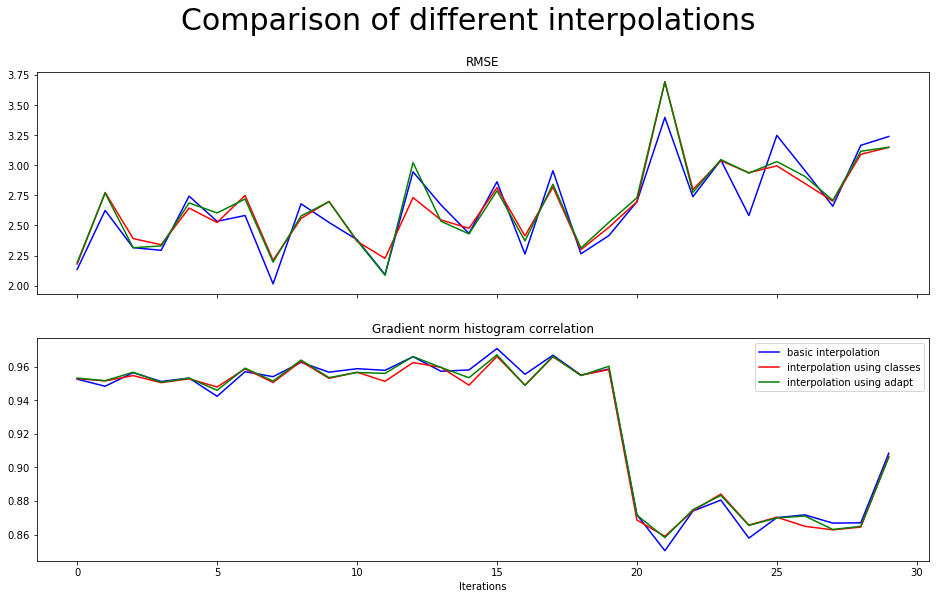

In [14]:
pylab.rcParams['figure.figsize'] = (16,9)

f, axarr = plt.subplots(2, 1, sharex='col', sharey='row')
p = axarr[0].plot(basic_rmse,'b',label='basic interpolation')
p = axarr[0].plot(fixed_rmse,'r', label='interpolation using classes')
p = axarr[0].plot(adapt_rmse,'g', label='interpolation using adapt')
axarr[0].set_title('RMSE')
legend()
p = axarr[1].plot(basic_hist_error,'b',label='basic interpolation')
p = axarr[1].plot(fixed_hist_error,'r', label='interpolation using classes')
p = axarr[1].plot(adapt_hist_error,'g', label='interpolation using adapt')
axarr[1].set_title('Gradient norm histogram correlation')
axarr[1].set_xlabel('Iterations')
legend()
f.suptitle('Comparison of different interpolations',fontsize=30)